In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
import cv2
from PIL import Image
from tensorflow.keras.layers import Dense,Reshape,Conv2D,Flatten,Dropout,Input,MaxPooling2D,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow import py_function
import tensorflow 
import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

**Load training and testing data**

In [14]:
#Load training data for resnet
X_image_train_resnet  = np.load('/content/gdrive/My Drive/AIML/Capstone/Pneumonia_Detection/resnet/X_train_resnet_10000.npy')

In [15]:
# Load testing data fro resnet
X_image_test_resnet  = np.load('/content/gdrive/My Drive/AIML/Capstone/Pneumonia_Detection/resnet/X_test_resnet_2000.npy')

In [27]:
# Load resnet train target values
y_target_train_resnet = np.load('/content/gdrive/My Drive/AIML/Capstone/Pneumonia_Detection/y_target_train.npy')[0:10000]
y_box_train_resnet = np.load('/content/gdrive/My Drive/AIML/Capstone/Pneumonia_Detection/y_box_train.npy')[0:10000]

In [28]:
# Load resnet test target values
# Load testtarget values
y_target_test_resnet = np.load('/content/gdrive/My Drive/AIML/Capstone/Pneumonia_Detection/test_input_numpy/y_target_train.npy')[0:2000]
y_box_test_resnet = np.load('/content/gdrive/My Drive/AIML/Capstone/Pneumonia_Detection/test_input_numpy/y_box_train.npy')[0:2000]

In [29]:
# Make target values to categorical type both training and testing.
y_target_test_resnet = tf.keras.utils.to_categorical(y_target_test_resnet,num_classes=2)
y_target_train_resnet = tf.keras.utils.to_categorical(y_target_train_resnet,num_classes=2)

In [30]:
image_size = 224

In [31]:
# Here, I am using resnet model
# And using input shape (224,224,3) 3 channels.
# And using 'imagenet weights'. 
# This is the basic classification model.
def createModelResnet(trainBaseModel=True):
    inputShape = (image_size,image_size,3)

    basemodel = ResNet50(include_top=False,input_shape=inputShape)
    
    for layer in basemodel.layers:
        layer.trainable = trainBaseModel
    
    basemodel_output =  basemodel.get_layer('conv5_block3_3_conv').output

    flat_reg = Flatten()(basemodel_output)
    dense = Dense(512,activation='relu',name='MJ_1_layer_reg')(flat_reg)
    drop = Dropout(0.2)(dense)
    output_reg = Dense(4,activation='linear',name='output_reg')(drop)
    
    flat_class = Flatten()(basemodel_output)
    dense = Dense(512,activation='relu',name='MJ_1_layer_dense')(flat_class)
    drop = Dropout(0.2)(dense)
    output_class = Dense(2,activation='softmax',name='output_class')(drop)
    
    return Model(inputs=basemodel.input, outputs=[output_reg,output_class])

In [32]:
resnet_model = createModelResnet(False)

In [33]:
# define ou loss funtion
def iou_loss(y_true,y_pred):
  y_true = tf.reshape(y_true,[-1])
  y_pred = tf.reshape(y_pred,[-1])
  intersection = tf.reduce_sum(y_true * y_pred)
  score = (intersection + 1.0) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.0)
  return 1 - score

In [34]:
def iou_bce_loss(y_true,y_pred):
  return 0.5* tensorflow.keras.losses.categorical_crossentropy(y_true,y_pred) + 0.5 * iou_loss(y_true,y_pred)

In [35]:
# Use earlystcheckpoint
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", save_freq='epoch')

# Use earlystopping
stop = EarlyStopping(patience=2, mode="min",min_delta=0.01,monitor='output_class_loss' ) #monitor, on which base you want to stop by deafult val_loss

In [36]:
resnet_model.compile(loss=["mean_squared_error","categorical_crossentropy"], optimizer="adam", metrics=[iou_bce_loss,"accuracy"]) # Regression loss is MSE

# Fit the model
history_resnet = resnet_model.fit(X_image_train_resnet,[y_box_train_resnet,y_target_train_resnet], epochs=20, batch_size=128,callbacks=[stop])

Epoch 1/20
79/79 [==============================] - 33s 423ms/step - loss: 1190.6827 - output_reg_loss: 1189.0486 - output_class_loss: 1.6343 - output_reg_iou_bce_loss: 101.3611 - output_reg_accuracy: 0.5348 - output_class_iou_bce_loss: 1.0773 - output_class_accuracy: 0.7184
Epoch 2/20
79/79 [==============================] - 33s 414ms/step - loss: 1003.4545 - output_reg_loss: 1003.0093 - output_class_loss: 0.4452 - output_reg_iou_bce_loss: 96.1346 - output_reg_accuracy: 0.5289 - output_class_iou_bce_loss: 0.4469 - output_class_accuracy: 0.8047
Epoch 3/20
79/79 [==============================] - 32s 409ms/step - loss: 925.2509 - output_reg_loss: 924.8412 - output_class_loss: 0.4099 - output_reg_iou_bce_loss: 95.5689 - output_reg_accuracy: 0.5501 - output_class_iou_bce_loss: 0.4155 - output_class_accuracy: 0.8232
Epoch 4/20
79/79 [==============================] - 33s 416ms/step - loss: 844.2056 - output_reg_loss: 843.8252 - output_class_loss: 0.3801 - output_reg_iou_bce_loss: 95.2244 -

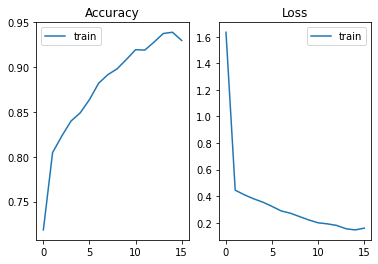

In [37]:
fig,ax = plt.subplots(1,2)
ax[0].set_title('Accuracy')
ax[0].plot(history_resnet.history['output_class_accuracy'],label='train')
# ax[0].plot(history.history['val_accuracy'],label='test')
ax[0].legend()

ax[1].set_title('Loss')
ax[1].plot(history_resnet.history['output_class_loss'],label='train')
# ax[1].plot(history.history['val_loss'],label='test')
ax[1].legend()
# By checking the accuracy and loss plots, suggest that the model has good fit on the problem.

In [38]:
# Evaluate model
resnet_model.evaluate(X_image_test_resnet,[y_box_test_resnet,y_target_test_resnet])

63/63 [==============================] - 6s 103ms/step - loss: 871.6815 - output_reg_loss: 870.7184 - output_class_loss: 0.9630 - output_reg_iou_bce_loss: 41.6113 - output_reg_accuracy: 0.4680 - output_class_iou_bce_loss: 0.7014 - output_class_accuracy: 0.7185


[871.6815185546875,
 870.7184448242188,
 0.9629501104354858,
 41.6113395690918,
 0.46799999475479126,
 0.7013540863990784,
 0.718500018119812]

**Testing**

In [39]:
pip install  pydicom

In [42]:
import os
import pydicom
import matplotlib.patches as patches

In [43]:
# define prediction function for predicting bounding boxes and classes.
def preditction(imagename):
    imageFolderPath = "/content/gdrive/MyDrive/AIML/Capstone/Pneumonia_Detection/liveTestPng"

    filepath = os.path.join(imageFolderPath,imagename)
    # print(filepath)

    unscaled = cv2.imread(filepath)
    image_height, image_width, _ = unscaled.shape
    image = cv2.resize(unscaled, (image_size, image_size)) # Rescaled image to run the network
    feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

    result = resnet_model.predict(x=np.array([feat_scaled]))
    region = result[0][0]
    class_result = np.argmax(result[1][0])

    print(f'Regions: {region}, Class is : {class_result}')

    x1 = int(region[0] * image_width/image_size)
    y1 = int(region[1] * image_height/image_size)

    x2= int((region[0] + region[2])  * image_width/image_size)
    y2 = int((region[1] + region[3]) * image_height/image_size)

    fig, ax = plt.subplots(1)
    ax.imshow(unscaled)
    rect = patches.Rectangle((x1,y1),x2-x1,y2-y1,edgecolor='r',facecolor='none',linestyle='-', linewidth=2)
    ax.add_patch(rect)


/content/gdrive/MyDrive/AIML/Capstone/Pneumonia_Detection/liveTestPng/265dd221-9049-4bca-b5c0-4118dafa55c5.png
Regions: [36.55676  13.513141 16.071415 23.838793], Class is : 1
/content/gdrive/MyDrive/AIML/Capstone/Pneumonia_Detection/liveTestPng/265ef9f1-3a21-4c9e-a8fe-740d8fae99f5.png
Regions: [12.7605715  6.7553234  6.13286    1.7509521], Class is : 0
/content/gdrive/MyDrive/AIML/Capstone/Pneumonia_Detection/liveTestPng/265f1a4a-fee4-447e-9709-0fff15f2255b.png
Regions: [-0.07475084 -3.7061105  -1.6174862  -1.8236779 ], Class is : 0
/content/gdrive/MyDrive/AIML/Capstone/Pneumonia_Detection/liveTestPng/265fc72c-f5f5-41bb-ac15-7ced161736df.png
Regions: [ 6.9833307   0.17080918 -0.3638166   2.3138087 ], Class is : 0
/content/gdrive/MyDrive/AIML/Capstone/Pneumonia_Detection/liveTestPng/26636455-c98d-49a1-8b48-7025f535f982.png
Regions: [72.61386  52.190586 21.740349 23.741941], Class is : 1
/content/gdrive/MyDrive/AIML/Capstone/Pneumonia_Detection/liveTestPng/2664366f-4f04-49e1-ab20-19b917

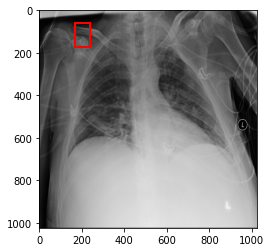

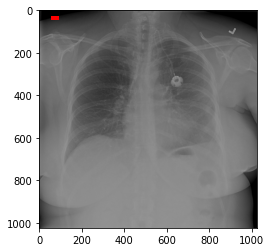

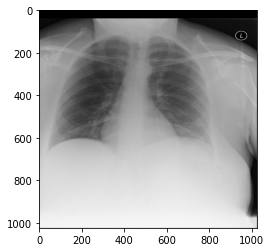

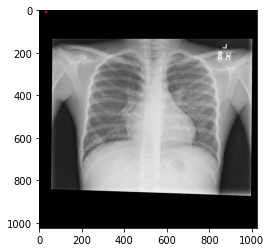

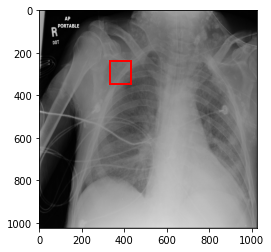

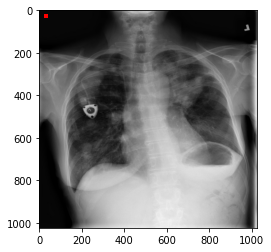

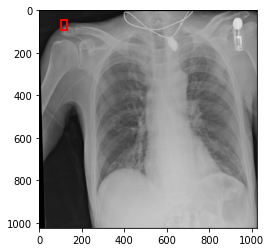

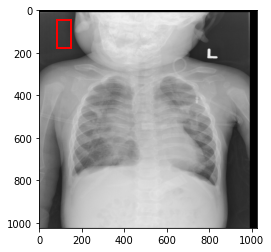

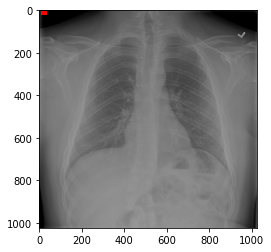

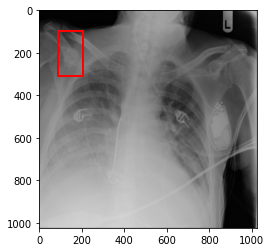

In [44]:
# ResNet50  testing
source_folder_path = "/content/gdrive/MyDrive/AIML/Capstone/Pneumonia_Detection/liveTestPng"
files = os.listdir(source_folder_path)
for index in range(20,30):
  file = files[index]
  imagPath = os.path.join(source_folder_path,file)
  print(imagPath)
  preditction(imagPath)

In [48]:
# serialize model to JSON
model_json = resnet_model.to_json()
with open("/content/gdrive/My Drive/AIML/Capstone/Pneumonia_Detection/preocessed_training_images/Channel_1/resnet_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
resnet_model.save_weights("/content/gdrive/My Drive/AIML/Capstone/Pneumonia_Detection/preocessed_training_images/Channel_1/resnet_model.h5")
print("Saved model to disk")

Saved model to disk
